In [1]:
import cv2
import sys, os
import argparse
import numpy as np
import torch
from pathlib import Path
from matplotlib import pyplot as plt
from typing import Any, Dict, List
import pandas as pd

from sam_segment import predict_masks_with_sam
from utils import load_img_to_array, save_array_to_img, dilate_mask, \
    show_mask, show_points, get_clicked_point

/raid/coss07/anaconda3/envs/IA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
img_folder_path =f'../wim_data/objects/images_object/'
mask_folder_path = f'../wim_data/objects/masks_object/'

In [53]:
file_names = [os.path.splitext(f)[0] for f in os.listdir(img_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
print(len(file_names))

38


In [6]:
# 파일 길이 기준
length_threshold = 40

# 길이가 50자 이하인 파일 삭제
for file_name in file_names:
    if len(file_name) <= length_threshold:
        os.remove(os.path.join(img_folder_path, file_name+'.jpg'))

# 삭제 후의 파일 개수 확인
remaining_files = [f for f in os.listdir(img_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
print("남은 파일 개수:", len(remaining_files))

남은 파일 개수: 11860


In [54]:
from PIL import Image
import random

# 이미지 폴더 경로 설정
obj_folder_path = '../wim_data/objects/images_object/'

# 이미지 파일 리스트 가져오기
object_files = [f for f in os.listdir(obj_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
print(len(object_files))

41


In [77]:
import random
# 이미지 및 객체 이미지 경로 설정
base_image_path = '../wim_data/objects/conveyer_resized.png'
object_images_folder = '../wim_data/objects/images_object/'
object_masks_folder = '../wim_data/objects/masks_object/'
output_folder = '../wim_data/crop_paste/crop_paste_random/'

In [147]:
def convert_to_yolo_label(x, y, w, h, img_width, img_height):
    # 중심 좌표 및 너비, 높이를 이미지 크기로 정규화
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return x_center, y_center, width, height

In [139]:
def extract_foreground(obj_img, mask_img):
    # 마스크에서 전경을 추출합니다.
    foreground = cv2.bitwise_and(obj_img, obj_img, mask=mask_img)
    return foreground

In [140]:
def overlap_ratio(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2

    # 겹치는 영역의 좌표와 크기를 계산
    x_overlap = max(0, min(x1+w1, x2+w2) - max(x1, x2))
    y_overlap = max(0, min(y1+h1, y2+h2) - max(y1, y2))
    overlap_area = x_overlap * y_overlap

    # 두 영역의 최소 넓이를 계산
    area1, area2 = w1*h1, w2*h2
    min_area = min(area1, area2)

    # 겹치는 영역의 비율을 계산
    if min_area == 0:
        return 0
    overlap_ratio = overlap_area / float(min_area)

    return overlap_ratio

In [157]:
# 겹치지 않는 위치를 찾는 함수
def find_non_overlapping_position2(obj_shape, existing_objects, rectangle, max_overlap=0.5):
    max_attempts = 100  # 겹치지 않는 위치를 찾기 위한 최대 시도 횟수
    obj_height, obj_width = obj_shape  # 객체의 높이와 너비

    for _ in range(max_attempts):
        # rectangle 영역 내에서 랜덤 위치를 생성
        
        if rectangle[2] > obj_width and rectangle[3] > obj_height:
            x_offset = random.randint(rectangle[0], rectangle[0] + rectangle[2] - obj_width)
            y_offset = random.randint(rectangle[1], rectangle[1] + rectangle[3] - obj_height)
            new_obj = (x_offset, y_offset, obj_width, obj_height)

            # 겹침이 허용된 범위 내인지 검사
            if all(overlap_ratio(new_obj, existing_obj) < max_overlap for existing_obj in existing_objects):
                return new_obj
        else:
            # The object is too large to fit within the rectangle, so skip it
            return None

    return None  # 겹치지 않는 위치를 찾지 못한 경우

In [142]:
# Helper function to check if two rectangles overlap
def is_overlapping(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2

    if x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2:
        return True  # Rectangles overlap
    return False  # Rectangles do not overlap

In [143]:
def find_non_overlapping_position(obj_shape, existing_objects, rectangle):
    max_attempts = 100  # 겹치지 않는 위치를 찾기 위한 최대 시도 횟수
    obj_height, obj_width = obj_shape  # 객체의 높이와 너비

    for _ in range(max_attempts):
        # rectangle 영역 내에서 랜덤 위치를 생성
        # Ensure the random offsets are within the rectangle bounds
        if rectangle[2] > obj_width and rectangle[3] > obj_height:
            x_offset = random.randint(rectangle[0], rectangle[0] + rectangle[2] - obj_width)
            y_offset = random.randint(rectangle[1], rectangle[1] + rectangle[3] - obj_height)
            new_obj = (x_offset, y_offset, obj_width, obj_height)

            # 겹치지 않는지 확인
            overlap = False
            for existing_obj in existing_objects:
                if is_overlapping(new_obj, existing_obj):
                    overlap = True
                    break
            
            if not overlap:
                return new_obj
        else:
            # The object is too large to fit within the rectangle, so skip it
            return None

    return None  # 겹치지 않는 위치를 찾지 못한 경우

In [154]:
# 기본 이미지 로드
base_image = cv2.imread(base_image_path)
img_height, img_width, _ = base_image.shape

# 지정된 영역 (x 시작, y 시작, 너비, 높이)
rectangle = (300, 0, 680, 740)

# 객체 이미지 목록 가져오기
object_images = [f for f in os.listdir(object_images_folder) if f.endswith('.jpg') or f.endswith('.png')]
random.shuffle(object_images) # 랜덤화
# 배경 이미지의 해당 영역에서 사용할 수 있는 최대 객체 수
max_objects = 7
# 객체 이미지 배치 및 라벨 생성
labels = []

In [155]:
len(object_images)

17236

In [158]:
# 객체 이미지 배치 및 라벨 생성
labels = []
classes = []
# 배치된 객체들과 그 위치를 저장할 리스트
placed_objects = []

for i, obj_img_name in enumerate(object_images):
    if i >= max_objects:  # 최대 객체 수 제한
        break
    parts = obj_img_name.split('_')
    obj_class = parts[2]
    
    obj_img_path = os.path.join(object_images_folder, obj_img_name)
    obj_img = cv2.imread(obj_img_path, -1)
    if obj_img is None:
        print(f"Image at {obj_img_path} could not be loaded.")
        continue
    
    # 알파 채널과 BGR 채널 분리
    alpha_channel = obj_img[:, :, 3]  # 알파 채널 추출
    obj_img = obj_img[:, :, :3]  # BGR 채널만 추출
    
    # 알파 채널을 마스크로 사용해 배경을 제거
    mask = alpha_channel / 255.0  # 정규화된 마스크
    mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)  # 마스크를 3채널(BGR)로 확장
    
    obj_img_float = obj_img.astype(float)  # obj_img를 생성된 마스크와 연산을 위해 부동소수점타입으로 변경
    obj_img = cv2.multiply(obj_img_float, mask_3d)
    
    # 마스킹된 이미지의 타입을 표준 이미지 타입인 uint8로 변환
    obj_img = cv2.convertScaleAbs(obj_img)
    
    # 객체의 크기를 가져옴
    obj_height, obj_width = obj_img.shape[:2]
    
    # 겹치지 않는 위치 찾기
    position = find_non_overlapping_position2((obj_height, obj_width), placed_objects, rectangle)
    if position is None:
        continue
    
    
    # 객체를 배경 이미지에 붙임
    x_offset, y_offset, _, _ = position
    y1, y2 = y_offset, y_offset + obj_height
    x1, x2 = x_offset, x_offset + obj_width
    alpha_s = mask.astype(float)
    alpha_l = 1.0 - alpha_s
    
    
    # Ensure the sliced dimensions are within the base image boundaries
    y1 = max(0, y1)
    y2 = min(base_image.shape[0], y2)
    x1 = max(0, x1)
    x2 = min(base_image.shape[1], x2)

    # Calculate the actual height and width of the slice
    slice_height = y2 - y1
    slice_width = x2 - x1

    # Resize or trim the object image and alpha mask if they don't fit
    if slice_height != obj_height or slice_width != obj_width:
        obj_img = cv2.resize(obj_img, (slice_width, slice_height))
        alpha_s = cv2.resize(alpha_s, (slice_width, slice_height))
        alpha_l = 1.0 - alpha_s
    
    
    # 알파 블렌딩을 사용하여 이미지를 합성합니다.
    for c in range(3):
        base_image[y1:y2, x1:x2, c] = alpha_s * obj_img[:, :, c] + alpha_l * base_image[y1:y2, x1:x2, c]

    placed_objects.append((x_offset, y_offset, obj_width, obj_height))
    classes.append(obj_class)


In [149]:
# 라벨 생성 코드
for i,position in enumerate(placed_objects):
    x_offset, y_offset, obj_width, obj_height = position
    # 라벨 좌표 및 바운딩 박스 크기를 계산
    yolo_label = convert_to_yolo_label(x_offset, y_offset, obj_width, obj_height, base_image.shape[1], base_image.shape[0])
    labels.append(f"{classes[i]} {yolo_label[0]} {yolo_label[1]} {yolo_label[2]} {yolo_label[3]}")

In [159]:
# 결과 이미지 저장
output_image_path = os.path.join(output_folder+'images/', 'test5.png')
cv2.imwrite(output_image_path, base_image)

# 라벨 파일 저장
with open(os.path.join(output_folder+'labels/', 'test5.txt'), 'w') as file:
    for label in labels:
        file.write(label + "\n")


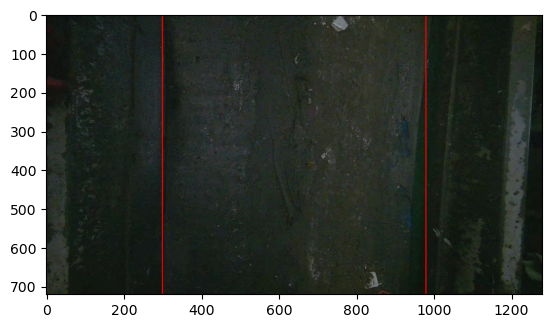

In [76]:

# 이미지 경로
image_path = '../wim_data/objects/conveyer_resized.png'

# 영역 정의 (x 시작, y 시작, 너비, 높이)
rectangle = (300, 0, 680, 740)  # 예시 좌표

# 이미지 로드
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 시각화할 사각형 그리기
start_point = (rectangle[0], rectangle[1])
end_point = (rectangle[0] + rectangle[2], rectangle[1] + rectangle[3])
color = (255, 0, 0)  # 빨간색
thickness = 2

image_with_rectangle = cv2.rectangle(image_rgb, start_point, end_point, color, thickness)

# 이미지 시각화
plt.imshow(image_with_rectangle)
plt.show()


In [111]:
# 이미 배치된 객체들의 위치를 저장할 리스트
placed_objects = []

for obj_img_name in object_images[:7]: # 최소 7개 객체
    parts = obj_img_name.split('_')
    obj_class = parts[2]  # 파일명에서 클래스 추출 (예: '1')
    obj_img_path = os.path.join(object_images_folder, obj_img_name)
    obj_img = cv2.imread(obj_img_path)
    
    
    
    
    # 객체 이미지와 마스크 이미지 로드
    _, mask = cv2.threshold(cv2.cvtColor(obj_img, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)
    
    foreground = extract_foreground(obj_img, mask)
    
    obj_shape = foreground.shape[:2]
    
    position = find_non_overlapping_position(obj_shape, placed_objects, rectangle)
    if position is not None:
        x_offset, y_offset, _, _ = position
        base_image[y_offset:y_offset+obj_shape[0], x_offset:x_offset+obj_shape[1]] = foreground
        placed_objects.append(position)
     
    # 라벨 생성
    bbox = [x_offset, y_offset, x_offset+obj_shape[1], y_offset+obj_shape[0]]
    yolo_label = convert_to_yolo_label(bbox, img_width, img_height)
    labels.append(f"{obj_class} {yolo_label[0]} {yolo_label[1]} {yolo_label[2]} {yolo_label[3]}")
